In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import matplotlib.pyplot as plt

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

np.set_printoptions(precision=2)

2024-06-24 13:50:30.376788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 13:50:30.376926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 13:50:30.526715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dataset = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv')
test_dataset = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv')

In [4]:
train_dataset.drop(columns=['id'], inplace=True)
test_dataset.drop(columns=['id'], inplace=True)

In [5]:
train_dataset[["Target"]].values

array([['Graduate'],
       ['Dropout'],
       ['Dropout'],
       ...,
       ['Enrolled'],
       ['Dropout'],
       ['Graduate']], dtype=object)

In [6]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()

train_dataset['Target'] = label_encoder.fit_transform(train_dataset['Target']) 
  
train_dataset['Target'].unique() 

# 2 for Graduate, 0 for Dropout, and 1 for Enrolled

array([2, 0, 1])

In [7]:
def filter_features(dataset):
    plt.figure(figsize=(train_dataset.shape[1],10))
    cor = dataset.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
    
    #Selecting highly correlated features
    cor_target = abs(cor["Target"])
    relevant_features = cor_target[cor_target>=0.5]
    
    return relevant_features

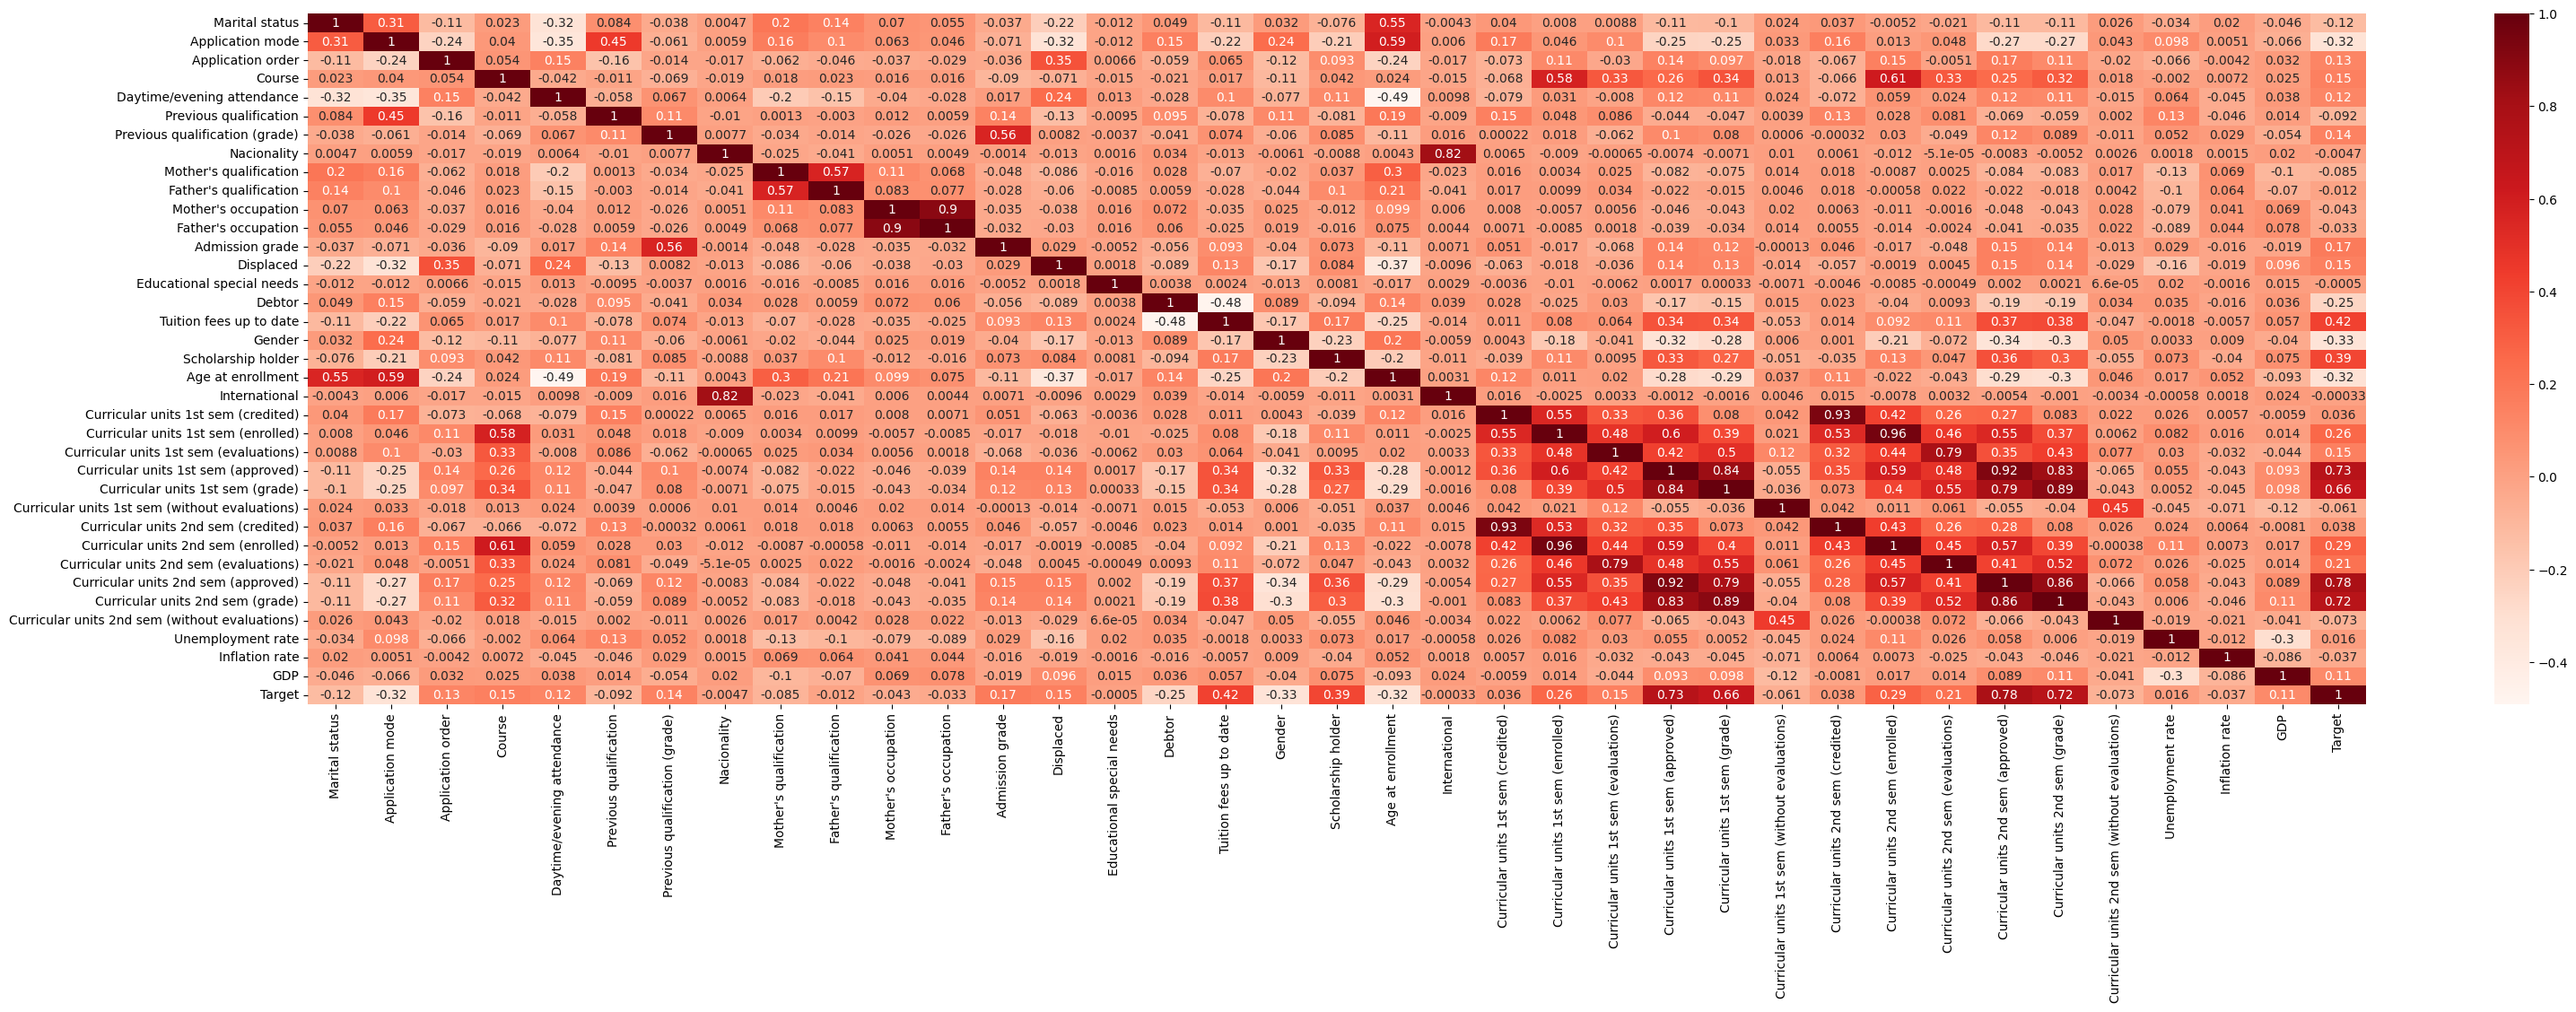

In [8]:
relevant_features = filter_features(train_dataset)

In [9]:
relevant_features

Curricular units 1st sem (approved)    0.725490
Curricular units 1st sem (grade)       0.661355
Curricular units 2nd sem (approved)    0.781452
Curricular units 2nd sem (grade)       0.719036
Target                                 1.000000
Name: Target, dtype: float64

In [10]:
X = train_dataset.drop(columns=['Target'])
y = train_dataset['Target']

# Standard scaling of features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
X.shape, y.shape

((76518, 36), (76518,))

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from xgboost import XGBClassifier


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [14]:
ANN_model = tf.keras.models.Sequential()
ANN_model.add(tf.keras.layers.Dense(units=400, activation='relu', input_shape=(36, )))
ANN_model.add(tf.keras.layers.Dropout(0.2))
ANN_model.add(tf.keras.layers.Dense(units=400, activation='relu'))
ANN_model.add(tf.keras.layers.Dropout(0.2))
ANN_model.add(tf.keras.layers.Dense(units=3, activation='linear'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
ANN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 400)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 400)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,403 (689.07 KB)

 Trainable params: 176,403 (689.07 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
ANN_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [17]:
history = ANN_model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=200,
    validation_data=(X_test, y_test),
)

Epoch 1/200
957/957 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.5266 - sparse_categorical_accuracy: 0.7953 - val_loss: 0.4651 - val_sparse_categorical_accuracy: 0.8200
Epoch 2/200
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4726 - sparse_categorical_accuracy: 0.8155 - val_loss: 0.4633 - val_sparse_categorical_accuracy: 0.8218
Epoch 3/200
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4627 - sparse_categorical_accuracy: 0.8197 - val_loss: 0.4705 - val_sparse_categorical_accuracy: 0.8228
Epoch 4/200
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4648 - sparse_categorical_accuracy: 0.8207 - val_loss: 0.4586 - val_sparse_categorical_accuracy: 0.8197
Epoch 5/200
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4547 - sparse_categorical_accuracy: 0.8253 - val_loss: 0.4595 - val_sparse_categorical_accuracy: 0.8207
Epoch 6/200
957/957 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4531 - sparse_categorical_accuracy: 0.8270 - val_loss: 0.4594 - val_sparse_categorical_accuracy: 0.821

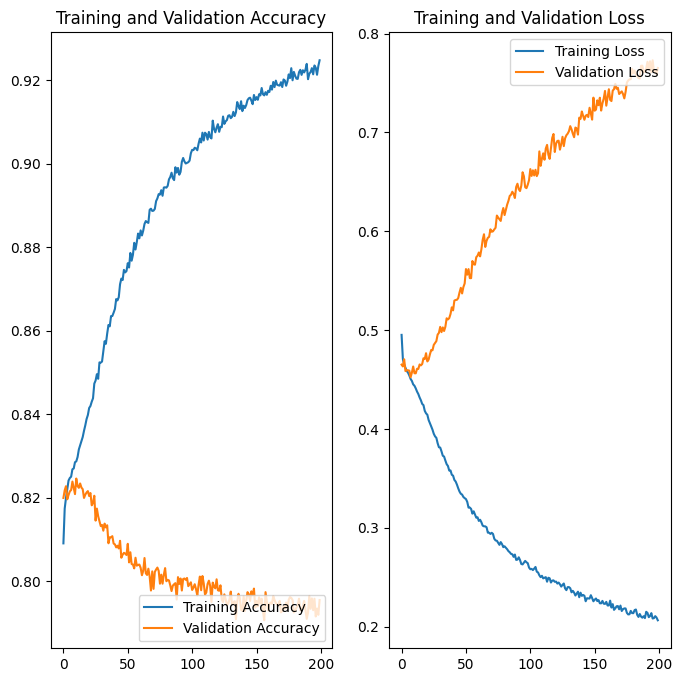

In [18]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(200)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
X_test_new = test_dataset
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_new)

In [20]:
y_pred = ANN_model.predict(X_test_scaled)

1595/1595 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [21]:
# 2 for Graduate, 0 for Dropout, and 1 for Enrolled
labels = [2, 0, 1]
yhat = []
for i in range(len(y_pred)):
    max_value_index = np.argmax(y_pred[i])
    yhat.append(labels[max_value_index])


In [22]:
yhat_cat = []
for i in range(len(yhat)):
    if yhat[i] == 0:
        yhat_cat.append('Dropout')
    elif yhat[i] == 1:
        yhat_cat.append('Enrolled')
    else:
        yhat_cat.append('Graduate')

In [23]:
submit = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
submit.Target = yhat_cat
submit[['id', 'Target']].to_csv('/kaggle/working/neural_network.csv', index=False)

### Build a XGBoost Model

In [24]:
!pip install xgboost

In [26]:
import xgboost as xgb
XGB_model = xgb.XGBClassifier(learning_rate = 0.2, max_depth = 3, n_estimators = 200)
XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [27]:
result_test = XGB_model.score(X_test, y_test)
print("Accuracy : {}".format(result_test))

Accuracy : 0.8325927861996864


In [28]:
X_test_scaled.shape

(51012, 36)

In [29]:
y_pred = XGB_model.predict(X_test_scaled)

In [30]:
y_pred

array([0, 2, 0, ..., 0, 0, 0])

In [31]:
yhat_cat = []
for i in range(len(y_pred)):
    if y_pred[i] == 0:
        yhat_cat.append('Dropout')
    elif y_pred[i] == 1:
        yhat_cat.append('Enrolled')
    else:
        yhat_cat.append('Graduate')

In [32]:
submit = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
submit.Target = yhat_cat
submit[['id', 'Target']].to_csv('/kaggle/working/xgboost.csv', index=False)